## 1. Import Libraries

In [1]:
import numpy as np

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

import eda_helper_functions

from sklearn.ensemble import IsolationForest

## 2. Read the Training Data

In [2]:
file_path = r"N:\ml-projects\regression\flight-price-prediction-using-sagemaker\datasets\train.csv"

train = pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-03-24,Kolkata,Banglore,15:10:00,19:50:00,280,1.0,No Info,7476
1,Jet Airways,2019-03-21,Banglore,New Delhi,08:55:00,23:00:00,845,1.0,In-flight meal not included,6992
2,Jet Airways,2019-06-09,Banglore,Delhi,18:55:00,22:00:00,185,0.0,In-flight meal not included,7229
3,Air India,2019-03-18,Banglore,New Delhi,17:00:00,19:45:00,165,0.0,No Info,4441
4,Spicejet,2019-03-03,Banglore,New Delhi,09:35:00,12:30:00,175,0.0,No Info,6860
...,...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-05-24,Kolkata,Banglore,20:00:00,10:05:00,845,1.0,In-flight meal not included,8586
636,Jet Airways,2019-06-27,Delhi,Cochin,21:50:00,19:00:00,1270,1.0,In-flight meal not included,10262
637,Air Asia,2019-03-03,Banglore,New Delhi,05:50:00,08:40:00,170,0.0,No Info,7652
638,Air India,2019-05-24,Kolkata,Banglore,19:00:00,04:40:00,580,1.0,No Info,6327


### 2.1 Fixing Data Types

In [3]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [4]:
train = train.assign(**{
	col: pd.to_datetime(train.loc[:, col], dayfirst=True, format="mixed")
	for col in ["date_of_journey", "dep_time", "arrival_time"]
})

train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

In [5]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-03-24,Kolkata,Banglore,2024-05-05 15:10:00,2024-05-05 19:50:00,280,1.0,No Info,7476
1,Jet Airways,2019-03-21,Banglore,New Delhi,2024-05-05 08:55:00,2024-05-05 23:00:00,845,1.0,In-flight meal not included,6992
2,Jet Airways,2019-06-09,Banglore,Delhi,2024-05-05 18:55:00,2024-05-05 22:00:00,185,0.0,In-flight meal not included,7229
3,Air India,2019-03-18,Banglore,New Delhi,2024-05-05 17:00:00,2024-05-05 19:45:00,165,0.0,No Info,4441
4,Spicejet,2019-03-03,Banglore,New Delhi,2024-05-05 09:35:00,2024-05-05 12:30:00,175,0.0,No Info,6860
...,...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-05-24,Kolkata,Banglore,2024-05-05 20:00:00,2024-05-05 10:05:00,845,1.0,In-flight meal not included,8586
636,Jet Airways,2019-06-27,Delhi,Cochin,2024-05-05 21:50:00,2024-05-05 19:00:00,1270,1.0,In-flight meal not included,10262
637,Air Asia,2019-03-03,Banglore,New Delhi,2024-05-05 05:50:00,2024-05-05 08:40:00,170,0.0,No Info,7652
638,Air India,2019-05-24,Kolkata,Banglore,2024-05-05 19:00:00,2024-05-05 04:40:00,580,1.0,No Info,6327


## 3. High-level Summary of Data

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          640 non-null    object        
 1   date_of_journey  640 non-null    datetime64[ns]
 2   source           640 non-null    object        
 3   destination      640 non-null    object        
 4   dep_time         640 non-null    datetime64[ns]
 5   arrival_time     640 non-null    datetime64[ns]
 6   duration         640 non-null    int64         
 7   total_stops      640 non-null    float64       
 8   additional_info  640 non-null    object        
 9   price            640 non-null    int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 50.1+ KB


In [7]:
train.describe(include="number")

,duration,total_stops,price
count,640.000000,640.000000,640.000000
mean,612.921875,0.771875,8951.065625
std,487.443566,0.648453,4649.241258
min,75.000000,0.000000,1965.000000
25%,170.000000,0.000000,5173.250000
50%,497.500000,1.000000,8060.500000
75%,865.000000,1.000000,12034.500000
max,2280.000000,3.000000,36235.000000


In [8]:
(
	train
	.assign(total_stops=train["total_stops"].astype(object))
	.describe(include="O")
)

,airline,source,destination,total_stops,additional_info
count,640,640,640,640.0,640
unique,8,5,6,4.0,5
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,216,249,249,350.0,508


## 4. High-level analysis of Missing Values

In [9]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,


## 5. High level analysis of outlier

In [10]:
forest = IsolationForest(n_estimators=10, random_state=42)

In [11]:
(
	train
	.assign(outlier=forest.fit_predict(
		train
		.drop(columns="price")
		.select_dtypes(include="number")
	))
	.query("outlier == -1")
	# .duration
	# .describe()
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
0,Indigo,2019-03-24,Kolkata,Banglore,2024-05-05 15:10:00,2024-05-05 19:50:00,280,1.0,No Info,7476,-1
2,Jet Airways,2019-06-09,Banglore,Delhi,2024-05-05 18:55:00,2024-05-05 22:00:00,185,0.0,In-flight meal not included,7229,-1
5,Indigo,2019-05-01,Mumbai,Hyderabad,2024-05-05 19:05:00,2024-05-05 20:35:00,90,0.0,No Info,2754,-1
8,Indigo,2019-03-18,Mumbai,Hyderabad,2024-05-05 20:05:00,2024-05-05 21:35:00,90,0.0,No Info,2227,-1
10,Jet Airways,2019-05-18,Delhi,Cochin,2024-05-05 09:40:00,2024-05-05 04:25:00,1125,2.0,No Info,15129,-1
...,...,...,...,...,...,...,...,...,...,...,...
627,Jet Airways,2019-05-01,Kolkata,Banglore,2024-05-05 17:00:00,2024-05-05 22:05:00,1745,1.0,No Info,14151,-1
630,Indigo,2019-06-09,Delhi,Cochin,2024-05-05 15:10:00,2024-05-05 20:00:00,290,1.0,No Info,7060,-1
633,Air India,2019-06-24,Delhi,Cochin,2024-05-05 22:00:00,2024-05-05 19:15:00,1275,2.0,No Info,9181,-1
636,Jet Airways,2019-06-27,Delhi,Cochin,2024-05-05 21:50:00,2024-05-05 19:00:00,1270,1.0,In-flight meal not included,10262,-1


## 6. Pair Plots

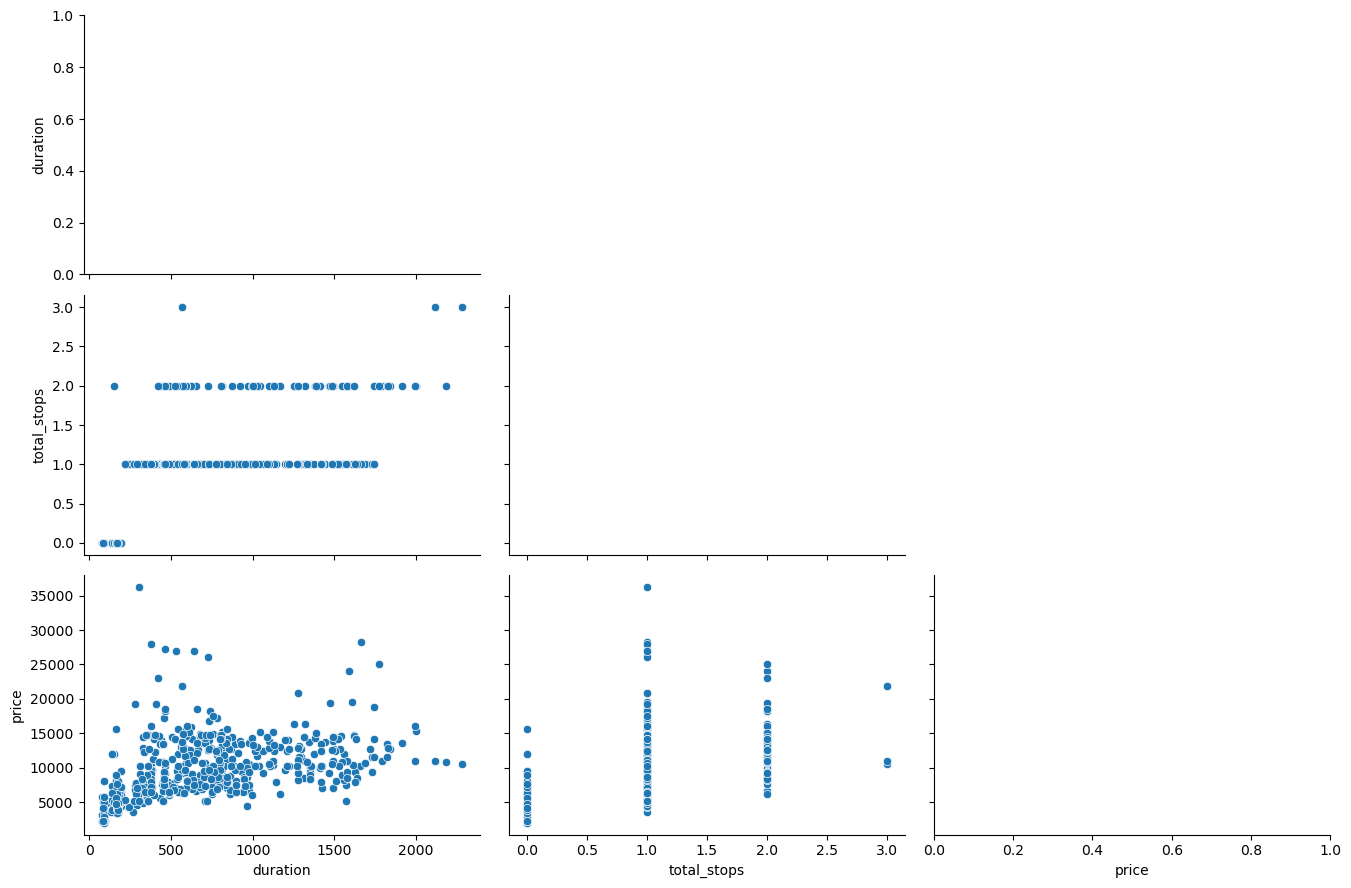

In [12]:
eda_helper_functions.pair_plots(train)

## 7. Correlation Analysis

C:\Users\Asus\anaconda3\envs\sagemaker\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


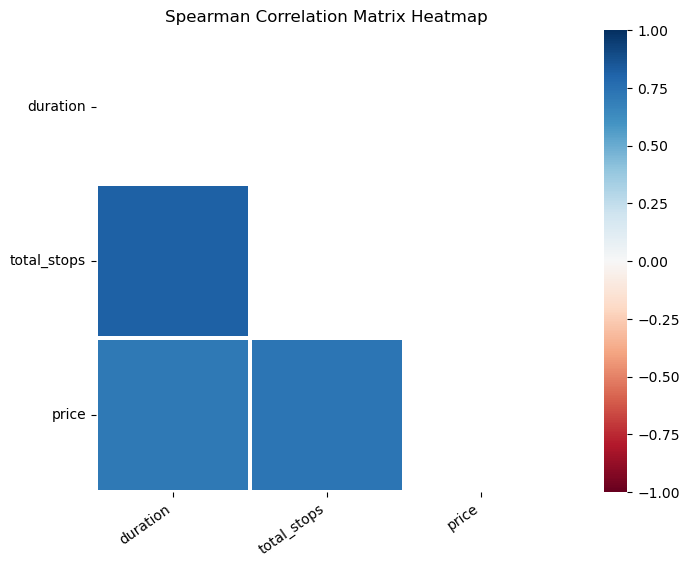

In [13]:
eda_helper_functions.correlation_heatmap(train)

C:\Users\Asus\anaconda3\envs\sagemaker\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


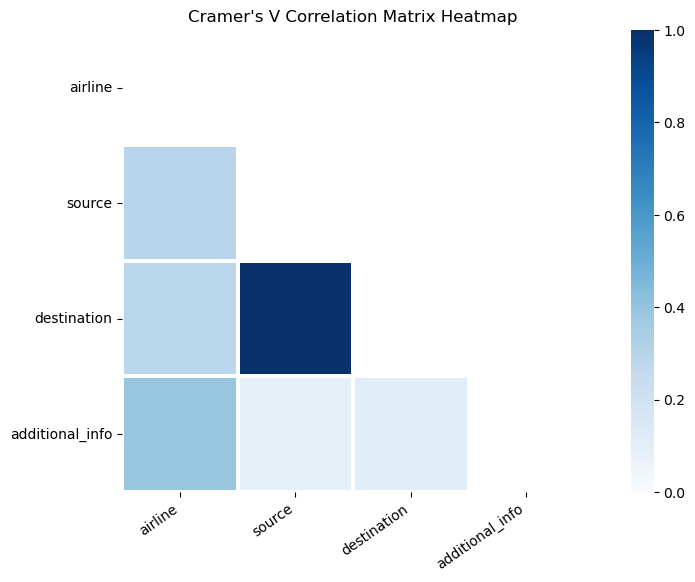

In [14]:
eda_helper_functions.cramersV_heatmap(train)

## 8. Detailed Analysis

In [15]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

### 8.1 airline

In [16]:
train.airline

0           Indigo
1      Jet Airways
2      Jet Airways
3        Air India
4         Spicejet
          ...     
635    Jet Airways
636    Jet Airways
637       Air Asia
638      Air India
639    Jet Airways
Name: airline, Length: 640, dtype: object

In [17]:
eda_helper_functions.cat_summary(train, "airline")

0           Indigo
1      Jet Airways
2      Jet Airways
3        Air India
4         Spicejet
          ...     
635    Jet Airways
636    Jet Airways
637       Air Asia
638      Air India
639    Jet Airways
Name: airline, Length: 640, dtype: object

Data Type      : object
Cardinality    : 8 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,
count,640
unique,8
top,Jet Airways
freq,216


,count,percentage
category,,
Jet Airways,216,0.337500
Indigo,132,0.206250
Air India,91,0.142187
Multiple Carriers,82,0.128125
Spicejet,51,0.079687
Vistara,36,0.056250
Goair,17,0.026562
Air Asia,15,0.023438


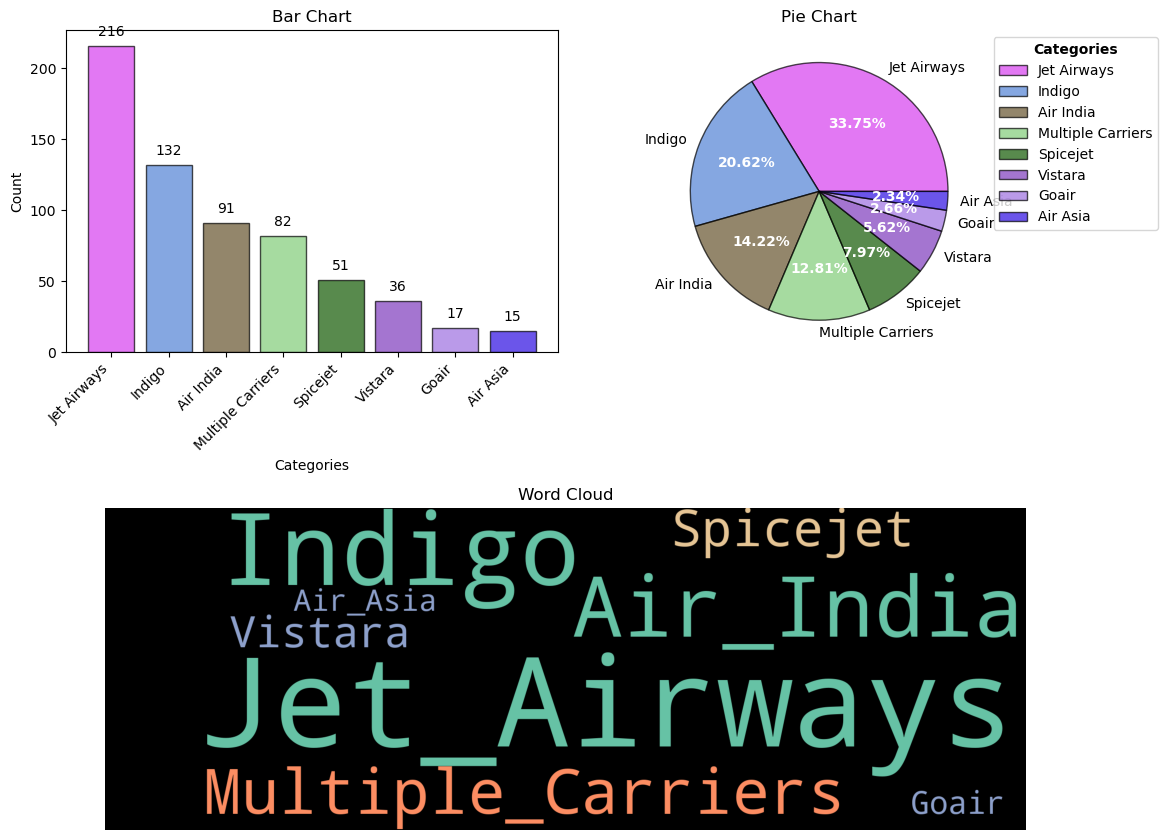

In [18]:
eda_helper_functions.cat_univar_plots(train, "airline")

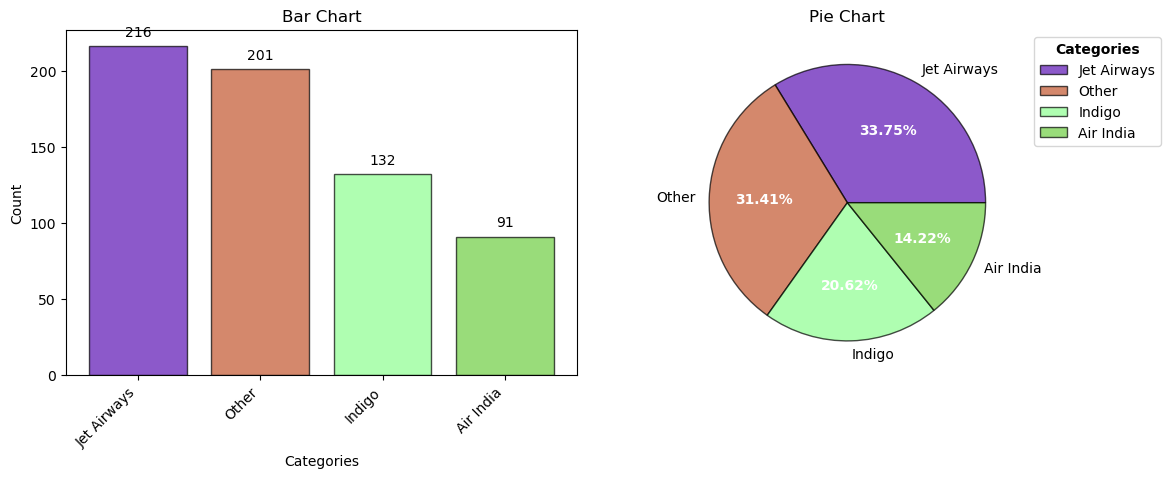

In [19]:
eda_helper_functions.cat_univar_plots(train, "airline", show_wordcloud=False, k=3)

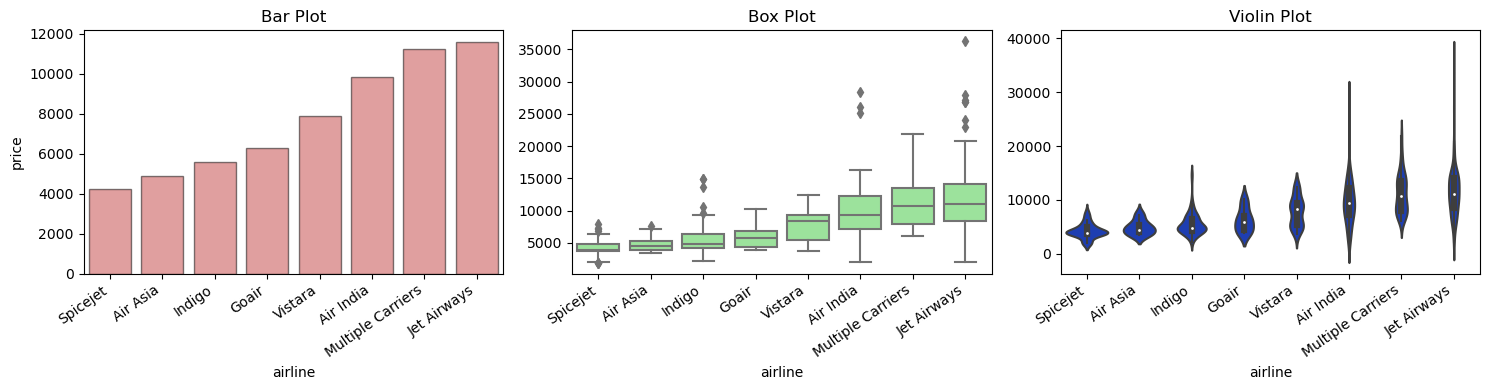

In [20]:
eda_helper_functions.num_cat_bivar_plots(
	data=train,
	num_var="price",
	cat_var="airline"
)

In [21]:
eda_helper_functions.num_cat_hyp_testing(train, "price", "airline")

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 52.024309516982875
- p-value              : 1.5856782571473733e-58
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 304.08261710030877
- p-value              : 8.124169653432942e-62
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


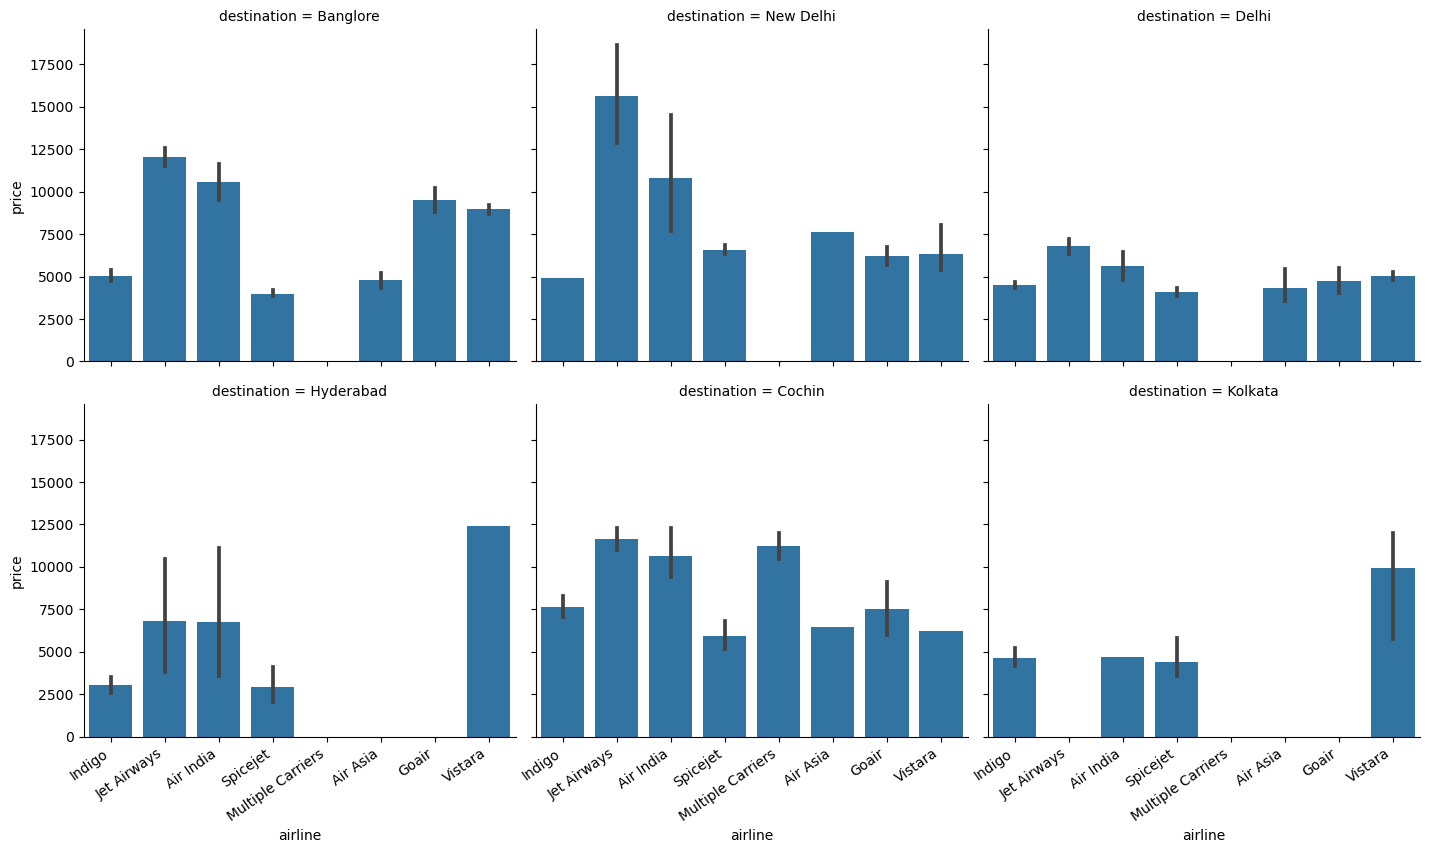

In [22]:
airline_grid = sns.FacetGrid(
	data=train,
	col="destination",
	col_wrap=3,
	height=4,
	aspect=1.2,
	sharey=True
)

airline_grid.map(sns.barplot, "airline", "price", order=train.airline.unique())

for ax in airline_grid.axes[3:]:
	eda_helper_functions.rotate_xlabels(ax)

### 8.2 date_of_journey

In [23]:
train.date_of_journey

0     2019-03-24
1     2019-03-21
2     2019-06-09
3     2019-03-18
4     2019-03-03
         ...    
635   2019-05-24
636   2019-06-27
637   2019-03-03
638   2019-05-24
639   2019-03-09
Name: date_of_journey, Length: 640, dtype: datetime64[ns]

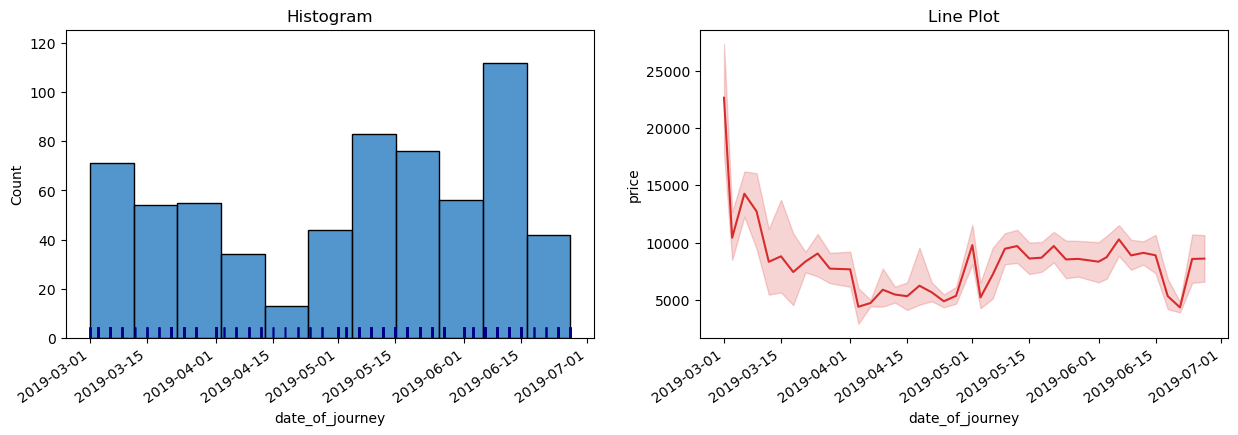

In [24]:
eda_helper_functions.dt_univar_plots(
	data=train,
	var="date_of_journey",
	target="price"
)

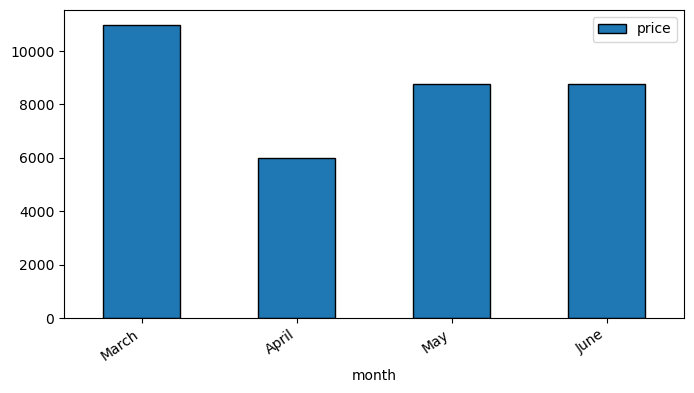

In [25]:
(
	train
	.groupby(pd.Grouper(key="date_of_journey", freq="M"))
	.price.mean()
	.to_frame()
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(8, 4),
		edgecolor="black"
	)
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

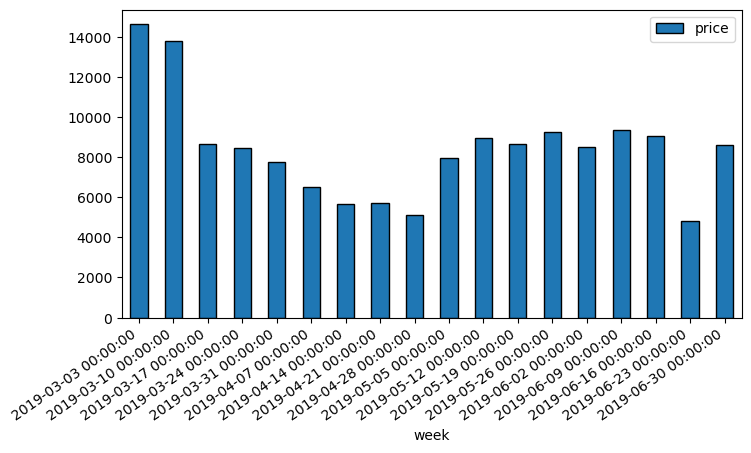

In [26]:
(
	train
	.groupby(pd.Grouper(key="date_of_journey", freq="W"))
	.price.mean()
	.to_frame()
	.rename_axis(index="week")
	.plot(
		kind="bar",
		figsize=(8, 4),
		edgecolor="black"
	)
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

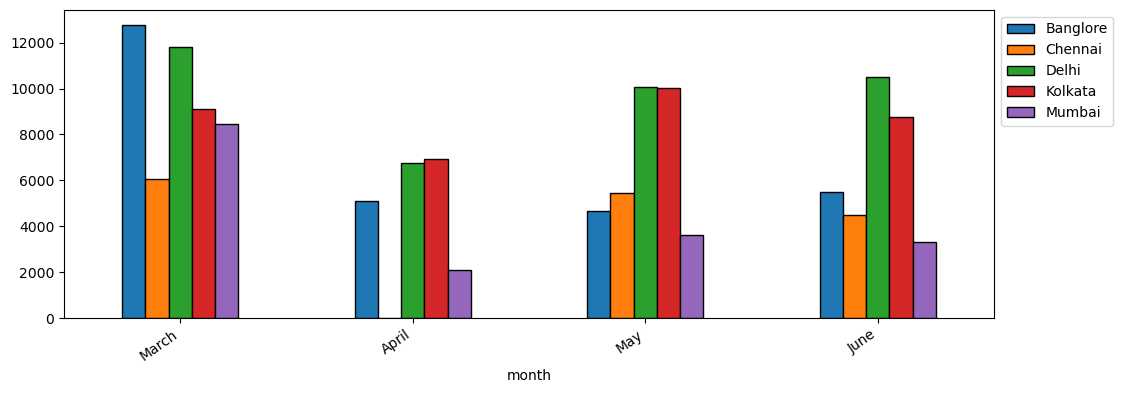

In [27]:
(
	train
	.groupby([pd.Grouper(key="date_of_journey", freq="M"), "source"])
	.price.mean()
	.unstack(fill_value=0)
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(12, 4),
		edgecolor="black"
	)
)

ax = plt.gca()

ax.legend(
	loc="upper left",
	bbox_to_anchor=(1, 1)
)

eda_helper_functions.rotate_xlabels(ax)

### 8.3 dep_time

In [28]:
train.dep_time

0     2024-05-05 15:10:00
1     2024-05-05 08:55:00
2     2024-05-05 18:55:00
3     2024-05-05 17:00:00
4     2024-05-05 09:35:00
              ...        
635   2024-05-05 20:00:00
636   2024-05-05 21:50:00
637   2024-05-05 05:50:00
638   2024-05-05 19:00:00
639   2024-05-05 08:55:00
Name: dep_time, Length: 640, dtype: datetime64[ns]

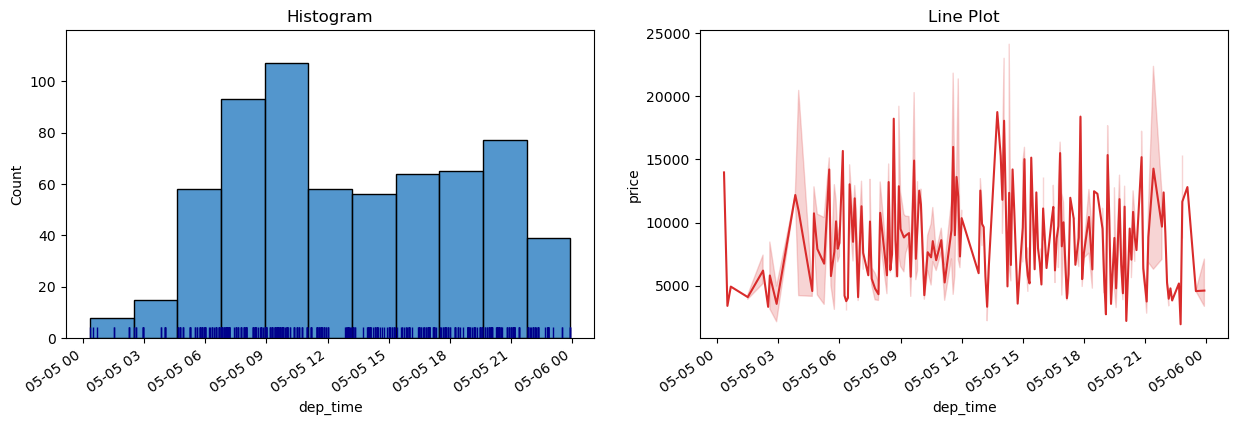

In [29]:
eda_helper_functions.dt_univar_plots(train, "dep_time", "price")

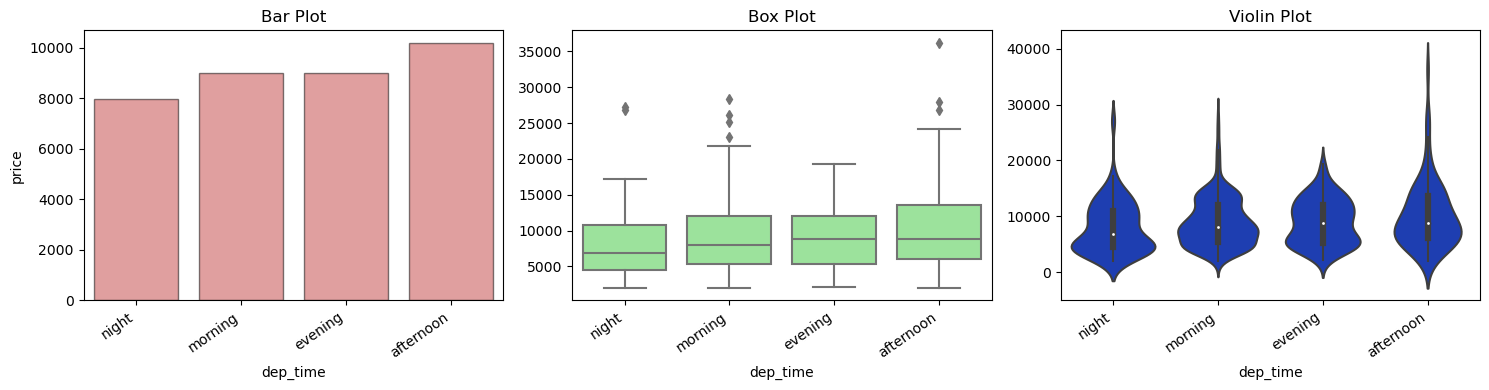

In [30]:
(
	train
	.assign(dep_time=lambda df_: (
		np.select([df_.dep_time.dt.hour.between(4, 12, inclusive="left"),
				   df_.dep_time.dt.hour.between(12, 16, inclusive="left"),
				   df_.dep_time.dt.hour.between(16, 20, inclusive="left")],
				  ["morning", "afternoon", "evening"],
				  default="night")
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "dep_time")
)

### 8.4 duration

In [31]:
train.duration

0       280
1       845
2       185
3       165
4       175
       ... 
635     845
636    1270
637     170
638     580
639     420
Name: duration, Length: 640, dtype: int64

In [32]:
eda_helper_functions.num_summary(train, "duration")

0       280
1       845
2       185
3       165
4       175
       ... 
635     845
636    1270
637     170
638     580
639     420
Name: duration, Length: 640, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,value
percentile,
0,75.00
5,90.00
10,140.00
25,170.00
50,497.50
75,865.00
90,1387.50
95,1580.00
99,1885.75


,value
mean,612.921875
trimmed mean (5%),577.404514
trimmed mean (10%),547.812500
median,497.500000


,value
var,237601.230194
std,487.443566
IQR,695.000000
mad,327.500000
coef_variance,0.795278


,value
skewness,0.932718
kurtosis,0.044242


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 1.9721123558577625e-21
Test Statistic       : 0.8846012785013532
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.782
Test Statistic       : 23.593993228496288
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


In [33]:
train.duration.quantile([0.25, 0.5, 0.75])

0.25    170.0
0.50    497.5
0.75    865.0
Name: duration, dtype: float64

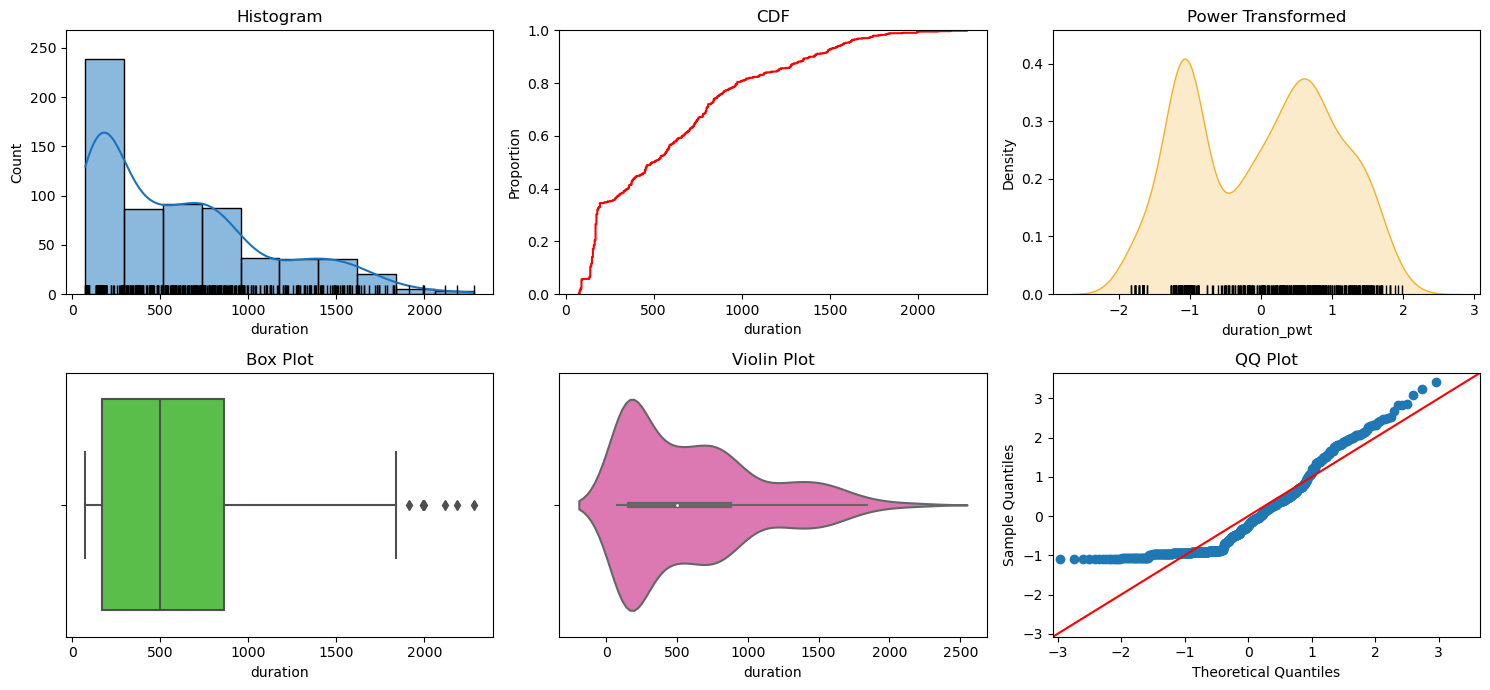

In [34]:
eda_helper_functions.num_univar_plots(train, "duration")

TypeError: Got both 'edgecolor' and 'edgecolors', which are aliases of one another

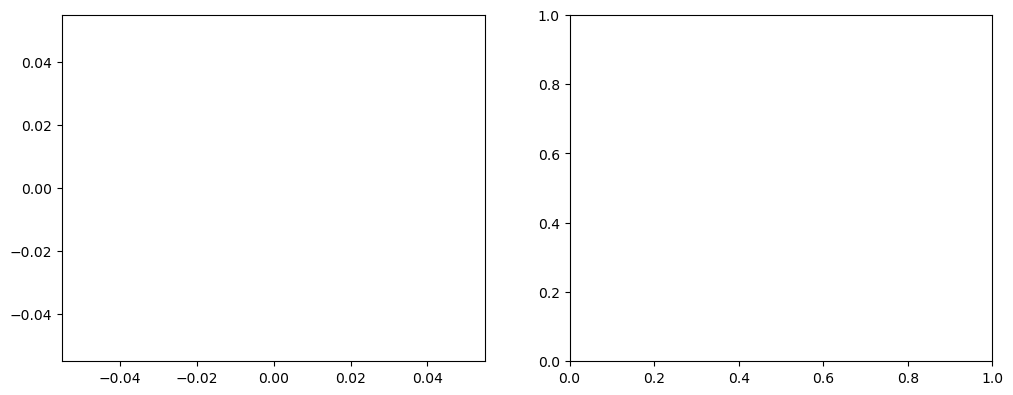

In [36]:
eda_helper_functions.num_bivar_plots(
	train,
	"duration",
	"price",
	hexbin_kwargs=dict(
		yscale="log",
		gridsize=20,
		cmap="Blues"
	)
)

In [37]:
eda_helper_functions.num_num_hyp_testing(train, "price", "duration")

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.5341947564379098
- p-value              : 1.6712807882600452e-48
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.7183316951951828
- p-value              : 1.2821806757285331e-102
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


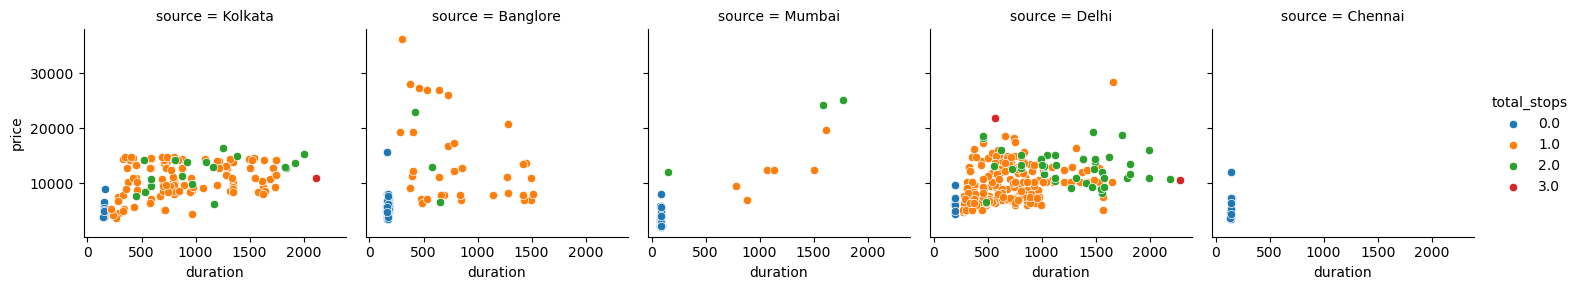

In [38]:
duration_grid = sns.FacetGrid(
	data=train,
	col="source",
	hue="total_stops",
	sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

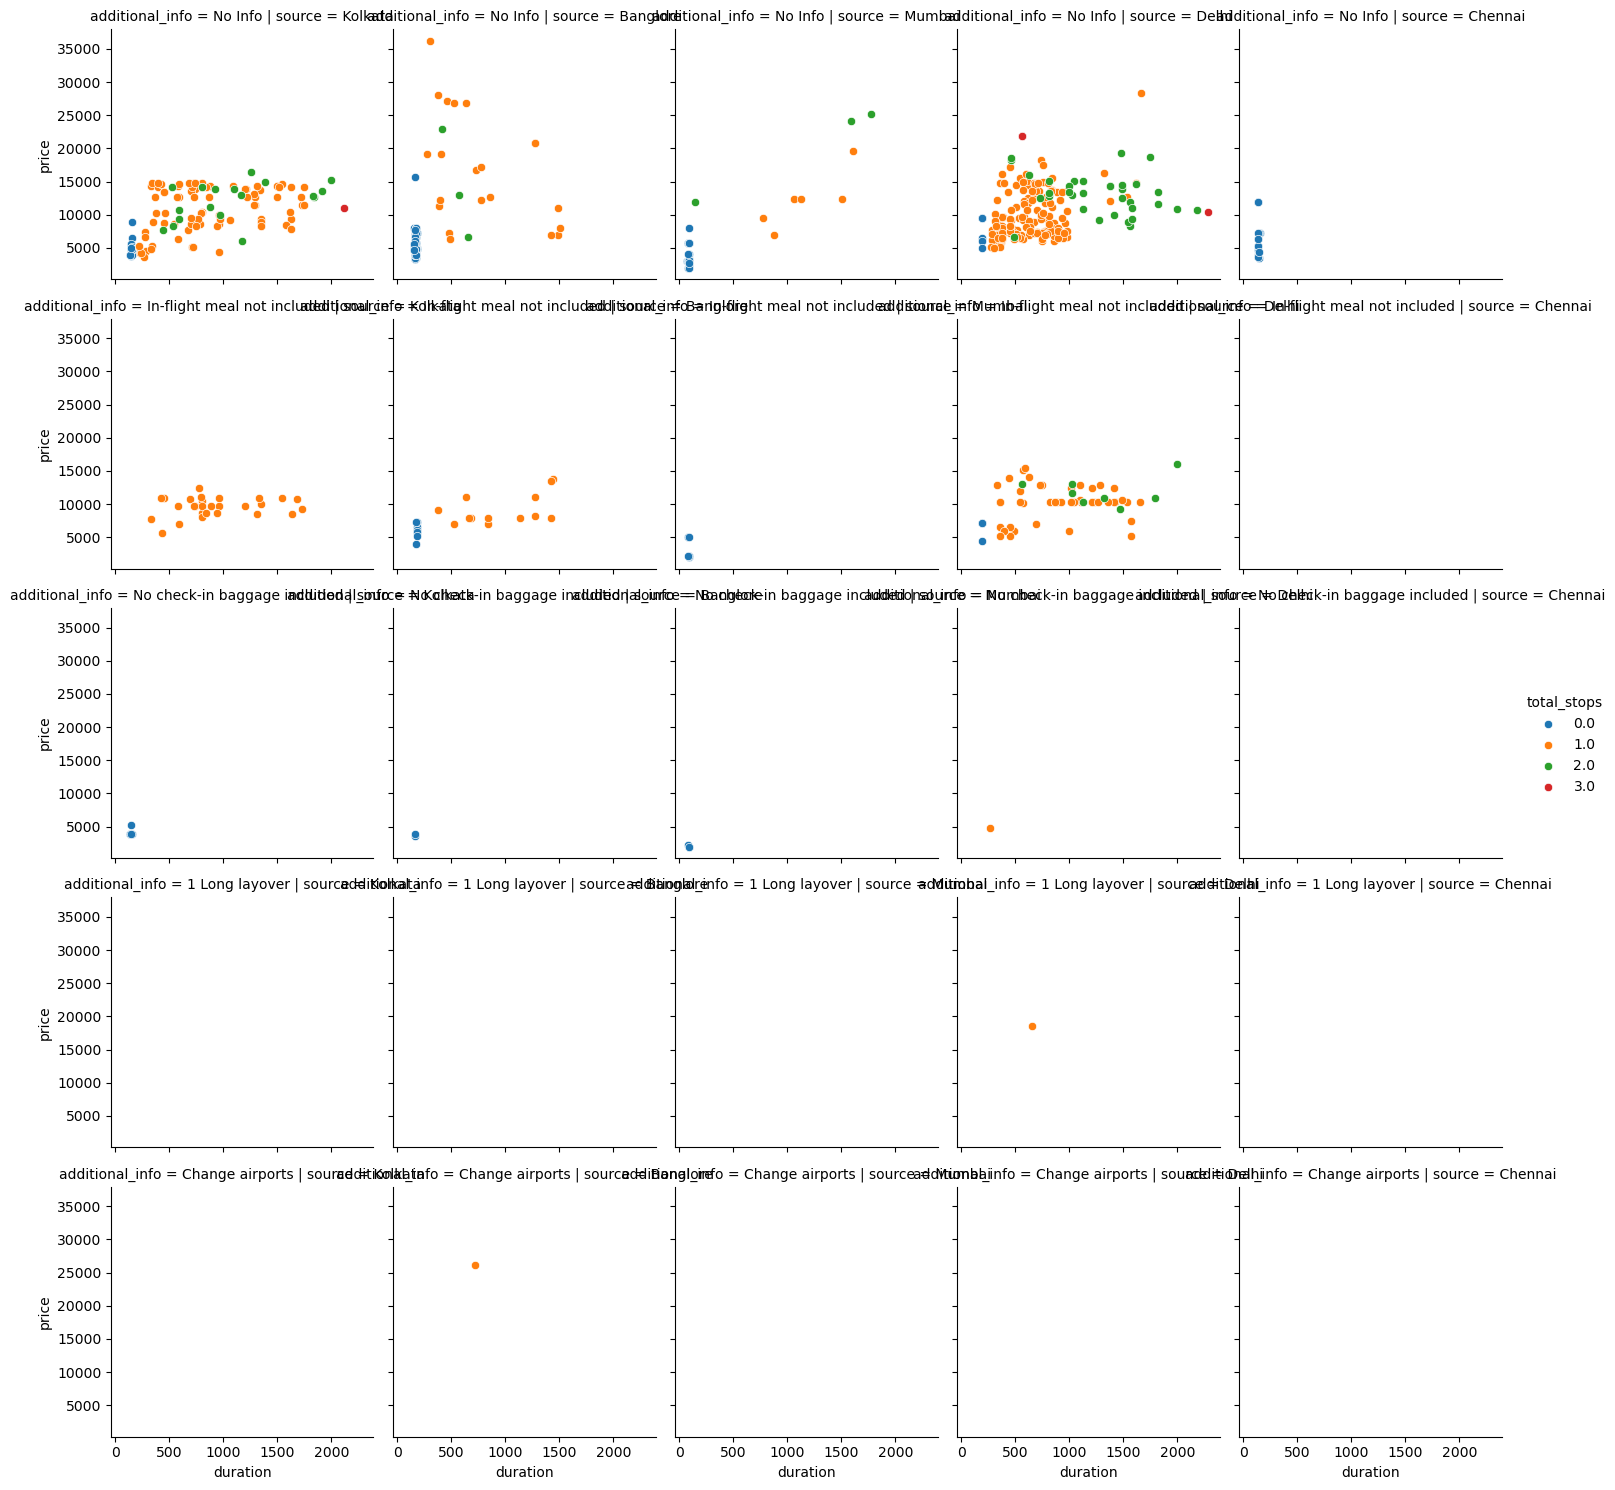

In [39]:
duration_grid = sns.FacetGrid(
	data=train,
	col="source",
	row="additional_info",
	hue="total_stops",
	sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

In [40]:
eda_helper_functions.get_iqr_outliers(train, "duration")

Lower Limit : -872.5
Upper Limit : 1907.5


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
420,Air India,2019-05-15,Kolkata,Banglore,2024-05-05 09:25:00,2024-05-05 17:20:00,1915,2.0,No Info,13616
416,Jet Airways,2019-03-06,Delhi,Cochin,2024-05-05 19:10:00,2024-05-05 04:25:00,1995,2.0,In-flight meal not included,16022
583,Jet Airways,2019-03-21,Delhi,Cochin,2024-05-05 19:10:00,2024-05-05 04:25:00,1995,2.0,No Info,10929
73,Air India,2019-03-24,Kolkata,Banglore,2024-05-05 13:55:00,2024-05-05 23:15:00,2000,2.0,No Info,15292
446,Air India,2019-05-12,Kolkata,Banglore,2024-05-05 12:00:00,2024-05-05 23:15:00,2115,3.0,No Info,10991
396,Air India,2019-03-21,Delhi,Cochin,2024-05-05 06:50:00,2024-05-05 19:15:00,2185,2.0,No Info,10756
223,Air India,2019-05-27,Delhi,Cochin,2024-05-05 05:15:00,2024-05-05 19:15:00,2280,3.0,No Info,10493


### 8.5 additional_info

In [41]:
eda_helper_functions.cat_summary(train, "additional_info")

0                          No Info
1      In-flight meal not included
2      In-flight meal not included
3                          No Info
4                          No Info
                  ...             
635    In-flight meal not included
636    In-flight meal not included
637                        No Info
638                        No Info
639                        No Info
Name: additional_info, Length: 640, dtype: object

Data Type      : object
Cardinality    : 5 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,
count,640
unique,5
top,No Info
freq,508


,count,percentage
category,,
No Info,508,0.793750
In-flight meal not included,114,0.178125
No check-in baggage included,16,0.025000
1 Long layover,1,0.001563
Change airports,1,0.001563


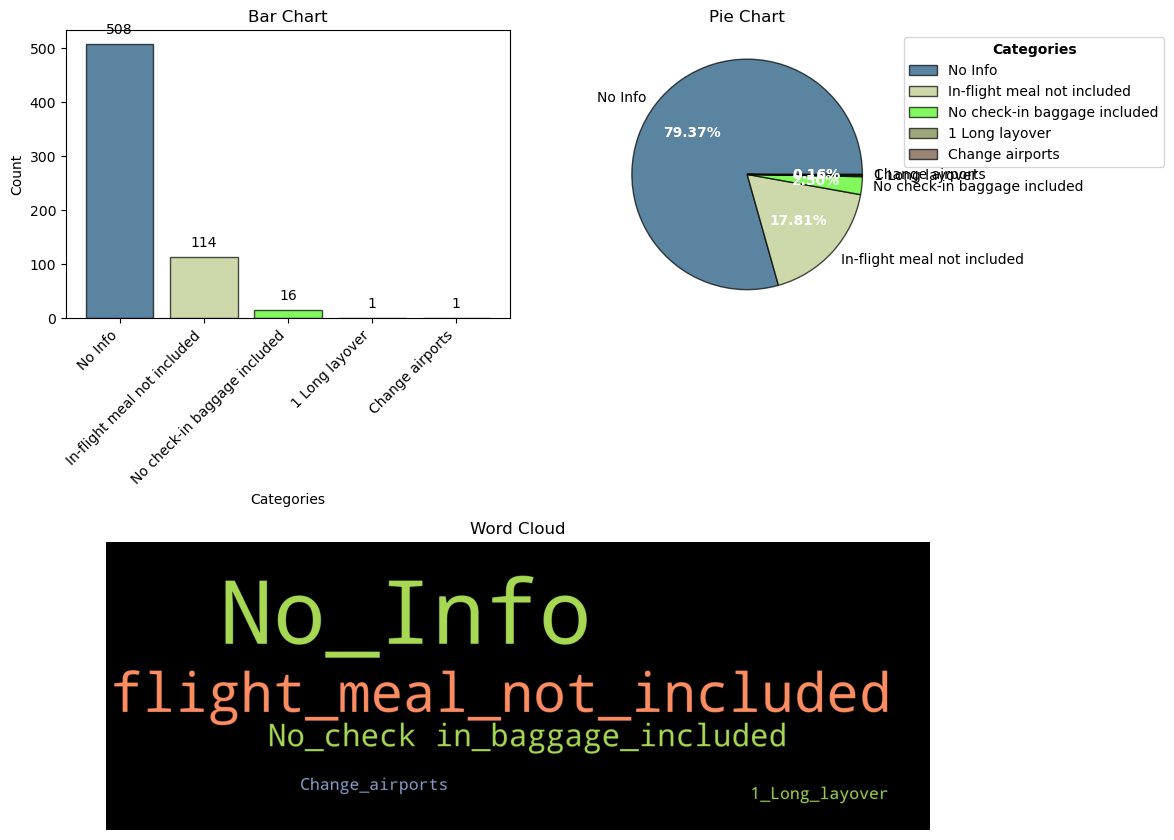

In [42]:
eda_helper_functions.cat_univar_plots(train, "additional_info")

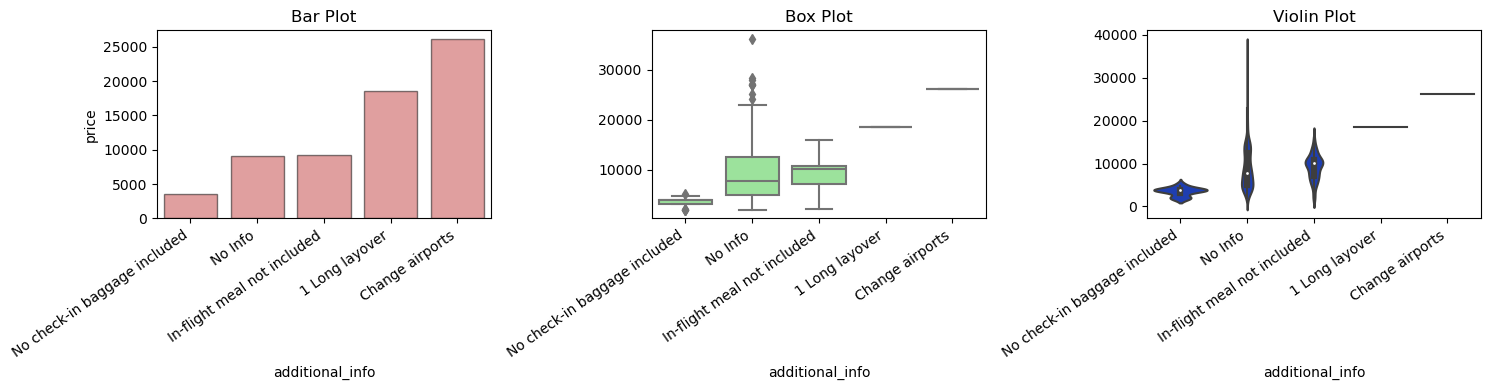

In [43]:
eda_helper_functions.num_cat_bivar_plots(train, "price", "additional_info")

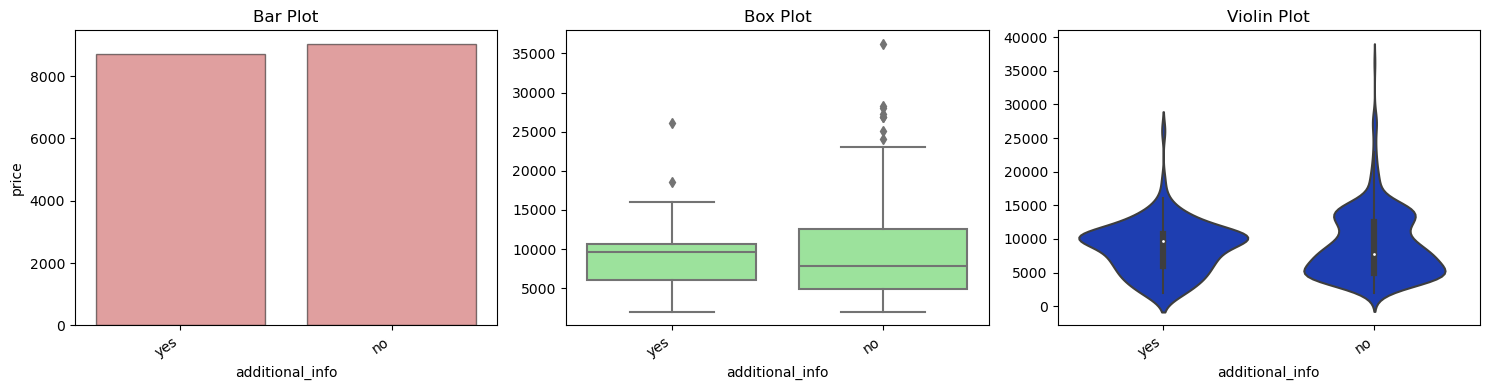

In [44]:
# convertion additional_info into a binary feature for analysis

(
	train
	.assign(additional_info=(
		train
		.additional_info
		.pipe(lambda ser: np.where(ser.eq("No Info"), "no", "yes"))
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "additional_info")
)

- `additional_info` has severely rare categories
- Converted it into a binary feature for further analysis

## 9. Automated EDA

In [45]:
# from ydata_profiling import ProfileReport

In [46]:
# report = ProfileReport(train)

In [47]:
# report.to_file(output_file="output.html")